## Naive Tokenization using a fixed Vocabulary

We need tokenization to represent text as something we can put into our neural networks. This process turns the most common words into integers. These integers can then be embedded using one hot encoding (a very poor choice) or by training an embedding layer as we train our network (or use a pretrained one). For a fixed vocabulary of size VOCAB_SIZE and a neural network with input_dim INPUT_DIM, our embedding layer would learn VOCAB_SIZE embeddings of size INPUT_DIM.

In [1]:
import re
from urllib import request

hamlet = request.urlopen("https://www.gutenberg.org/files/1524/1524-0.txt").read().decode('utf-8')

def clean_and_split(text:str)->list[str]:
    text = re.sub(r'[^\w\s,\.]', '', text) # remove non-alphanumeric
    text = re.sub(r'[^\w]|[\r\n]+', ' ', text) # replace commas and periods with space
    text = text.strip() # remove spaces in the beginning and end

    return [word.lower() for word in text.split(" ") if word]

hamlet = clean_and_split(hamlet)

Space will not be a token here but we will use it later (because after each and every token we can place a space)

In [2]:
counts = {}
for word in hamlet:
    if not word: continue # skip spaces

    word = word.lower()
    if word in counts:
        counts[word] += 1
    else:
        counts[word] = 0

In [3]:
num_words = sum(counts.values())
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
np.cumsum([x[1] for x in sorted_counts]).max(), num_words

(30067, 30067)

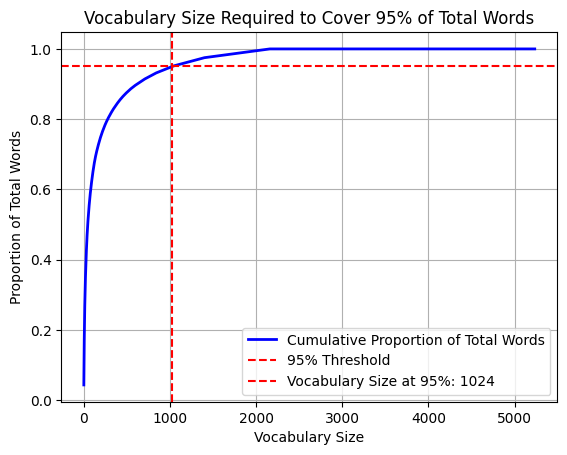

In [6]:
vocabulary_size = np.cumsum([x[1] for x in sorted_counts]) / num_words
threshold_index = np.argmax(vocabulary_size >= 0.95)  # Index where cumulative sum reaches or exceeds 95%


plt.plot(vocabulary_size, label='Cumulative Proportion of Total Words', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=threshold_index, color='r', linestyle='--', label=f'Vocabulary Size at 95%: {threshold_index}')
plt.xlabel('Vocabulary Size')
plt.ylabel('Proportion of Total Words')
plt.title('Vocabulary Size Required to Cover 95% of Total Words')
plt.grid(True)
plt.legend()

plt.show()

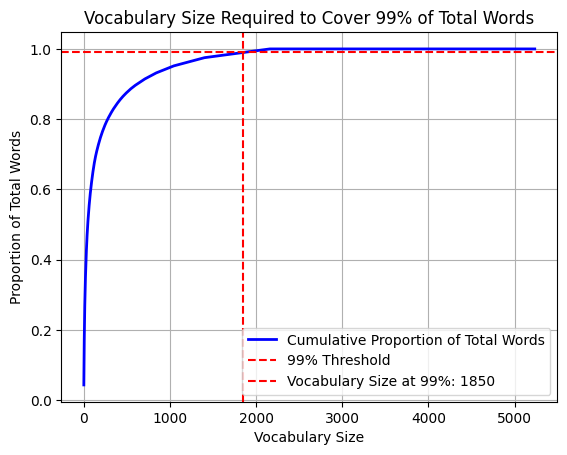

In [7]:
vocabulary_size = np.cumsum([x[1] for x in sorted_counts]) / num_words
threshold_index = np.argmax(vocabulary_size >= 0.99)  # Index where cumulative sum reaches or exceeds 99%


plt.plot(vocabulary_size, label='Cumulative Proportion of Total Words', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Threshold')
plt.axvline(x=threshold_index, color='r', linestyle='--', label=f'Vocabulary Size at 99%: {threshold_index}')
plt.xlabel('Vocabulary Size')
plt.ylabel('Proportion of Total Words')
plt.title('Vocabulary Size Required to Cover 99% of Total Words')
plt.grid(True)
plt.legend()

plt.show()

In [8]:
VOCAB_SIZE = 1024
SPECIAL_TOKENS = ["<BOS>", "<EOS>", "<UNK>"] # beginning of sentence, end of sentence, unknown

vocab = SPECIAL_TOKENS + [x[0] for x in sorted_counts[:(VOCAB_SIZE - len(SPECIAL_TOKENS))]]
word_to_idx = {x: i for i, x in enumerate(vocab)}
idx_to_word = {i: x for i, x in enumerate(vocab)}

Now we can tokenize Hamlet

In [9]:
sentence = "something is rotten in the state of denmark"
sentence

'something is rotten in the state of denmark'

In [10]:
def tokenize(sentence:str)->list[int]:
    words = clean_and_split(sentence)
    tokens = []
    for word in words:
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(word_to_idx["<UNK>"])
    return tokens

tokenize(sentence)

[291, 15, 2, 11, 3, 219, 6, 193]

In [11]:
def detokenize(tokens:list[int])->str:
    return " ".join(idx_to_word[t] for t in tokens)

detokenize(tokenize(sentence))

'something is <UNK> in the state of denmark'

In [12]:
sentence = """This above all: to thine own self be true,
And it must follow, as the night the day,
Thou canst not then be false to any man."""

print(clean_and_split(sentence))
print(tokenize(sentence))
print(detokenize(tokenize(sentence)))

['this', 'above', 'all', 'to', 'thine', 'own', 'self', 'be', 'true', 'and', 'it', 'must', 'follow', 'as', 'the', 'night', 'the', 'day', 'thou', 'canst', 'not', 'then', 'be', 'false', 'to', 'any', 'man']
[16, 908, 43, 5, 322, 135, 2, 23, 207, 4, 13, 80, 214, 25, 3, 141, 3, 224, 53, 2, 17, 90, 23, 646, 5, 116, 111]
this above all to thine own <UNK> be true and it must follow as the night the day thou <UNK> not then be false to any man


## BPE

## Tokenizing python code (Mix of both)
Create fixed token representation for things like keywords and parentheses while doing BPE on the characters in:

    -variables
    -variable names
    -function names
    -comments
    -etc

This is not strictly necessary but I believe it will help since we will be training quite small models. Will probably also reduce the amount of synxtax errors. 

In [13]:
import tokenize

tokenize.EQUAL, ord("=") # not ascii

(22, 61)

In [14]:
from io import BytesIO


python_code = """
# sum from 1 to 9
accumulator = 0 # accumulates the sum
for i in range(10):
    accumulator += 1
"""

list(x.string for x in tokenize.tokenize(BytesIO(python_code.encode("utf-8")).readline)) # don't know why utf-8 is there

['utf-8',
 '\n',
 '# sum from 1 to 9',
 '\n',
 'accumulator',
 '=',
 '0',
 '# accumulates the sum',
 '\n',
 'for',
 'i',
 'in',
 'range',
 '(',
 '10',
 ')',
 ':',
 '\n',
 '    ',
 'accumulator',
 '+=',
 '1',
 '\n',
 '',
 '']